# Forecasting NASDAQ Composite Stocks

### Importing the libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

### Downloading 'NASDAQ Composite' Dataset from Yahoo Finance

In [2]:
dataset = yf.download('^IXIC','2010-01-11','2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [3]:
dataset.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-11,2324.780029,2326.280029,2302.209961,2312.409912,2312.409912,2077890000
2010-01-12,2297.280029,2298.850098,2272.699951,2282.310059,2282.310059,2368320000
2010-01-13,2289.459961,2313.030029,2274.120117,2307.899902,2307.899902,2318350000
2010-01-14,2303.310059,2322.560059,2303.290039,2316.739990,2316.739990,2254170000
2010-01-15,2316.979980,2322.540039,2279.199951,2287.989990,2287.989990,2637770000
2010-01-19,2291.020020,2320.399902,2290.679932,2320.399902,2320.399902,2045290000
2010-01-20,2304.310059,2304.469971,2268.679932,2291.250000,2291.250000,2351890000
2010-01-21,2298.229980,2308.979980,2259.820068,2265.699951,2265.699951,2877800000
2010-01-22,2255.760010,2262.270020,2200.370117,2205.290039,2205.290039,2817620000


### Resampling Data on Weekly Basis (Starting on Monday)

In [0]:
dataset = dataset.resample(rule='W-MON').mean()

### Setting Index Frequency

In [0]:
dataset.index.freq = 'W-MON'

In [6]:
dataset.index

DatetimeIndex(['2010-01-11', '2010-01-18', '2010-01-25', '2010-02-01',
               '2010-02-08', '2010-02-15', '2010-02-22', '2010-03-01',
               '2010-03-08', '2010-03-15',
               ...
               '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18',
               '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16',
               '2019-12-23', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=521, freq='W-MON')

### Plotting the 'Open' Column

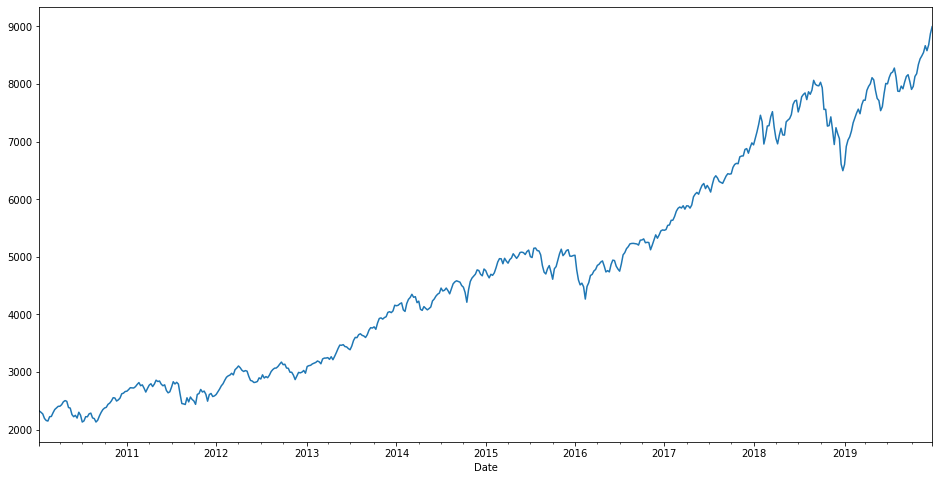

In [7]:
dataset['Open'].plot(figsize = (16,8))

### ETS Decomposition of the 'Open' column

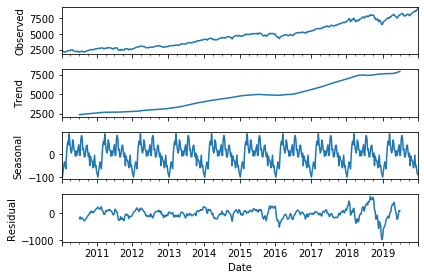

In [8]:
result = seasonal_decompose(dataset['Open'], model='add')
result.plot();

##### *A good upward trend with negligible seasonality.*

### Performing Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ''): # Pass in a time-series & an optional title. Returns an ADF Report.
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag = 'AIC') # dropna() handles differenced data.
    labels = ['ADF Test Statistics', 'p-value', 'Number of Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index = labels)
    
    for key, value in result[4].items():
        out[f'Critical Value (%s)'% key] = value
    print(out.to_string()) # to_string removes the line dtype: float64
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis',
              '\nReject the null hypothesis',
              '\nData has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis',
              '\nFail to reject the null hypothesis',
              '\nData has a unit root & is non-stationary')
        
adf_test(dataset['Open'], title = 'Open')

Augmented Dickey-Fuller Test: Open
ADF Test Statistics              0.953433
p-value                          0.993749
Number of Lags Used              2.000000
Number of Observations Used    518.000000
Critical Value (1%)             -3.443037
Critical Value (5%)             -2.867136
Critical Value (10%)            -2.569750
Weak evidence against the null hypothesis 
Fail to reject the null hypothesis 
Data has a unit root & is non-stationary


### Using Pyramid ARIMA we will find the best ARIMA order

In [10]:
stepwise_fit = auto_arima(dataset['Open'], start_p = 0, start_q = 0, seasonal = False, trace = True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=6116.288, BIC=6124.796, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=6100.306, BIC=6113.067, Fit time=0.087 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=6095.842, BIC=6108.603, Fit time=0.272 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=6125.641, BIC=6129.895, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=6096.286, BIC=6113.301, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=6095.419, BIC=6112.434, Fit time=0.419 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=6095.446, BIC=6116.715, Fit time=0.986 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=6095.912, BIC=6117.182, Fit time=0.365 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=6094.087, BIC=6119.609, Fit time=1.164 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=6096.017, BIC=6125.794, Fit time=1.422 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 0, 0); AIC=6096.049, BIC=6125.826, Fit time=1.564 seconds
Fit ARIMA: order=(0, 1, 4) seasonal_order=(0, 0, 0, 0); AIC=6097.621, BIC=6123.144, Fit time=0.757 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=6098.200, BIC=6123.723, Fit time=0.593 seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 0, 0, 0); AIC=6098.048, BIC=6132.078, Fit time=1.194 seconds
Total fit time: 9.329 seconds


In [11]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  521
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -3041.043
Date:                Wed, 12 Feb 2020   AIC                           6094.087
Time:                        04:44:45   BIC                           6119.609
Sample:                             0   HQIC                          6104.085
                                - 521                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     23.5464      8.774      2.684      0.007       6.350      40.742
ar.L1         -0.8405      0.123     -6.852      0.000      -1.081      -0.600
ma.L1          1.0562      0.128      8.283      0.000       0.806       1.306
ma.L2          0.0886      0.055      1.603      0.109      -0.020       0.197
ma.L3         -0.1223      0.030     -4.086      0.000      -0.181      -0.064
sigma2      7031.0580    297.569     23.628      0.000    6447.833    7614.283
===================================================================================
Ljung-Box (Q):                       52.35   Jarque-Bera (JB):               293.83
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               4.25   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### *Although it shows SARIMAX(1, 1, 3), we will use ARIMA(1, 1, 3).*

### Splitting the Dataset into Training & Test Sets

In [0]:
train = dataset.iloc[:509] # We will keep 12 weeks for the Test Set
test = dataset.iloc[509:]

### Fitting ARIMA onto the Training Set

In [13]:
model = ARIMA(train['Open'], order = (1, 1, 3))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Open   No. Observations:                  508
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -2968.598
Method:                       css-mle   S.D. of innovations             83.483
Date:                Wed, 12 Feb 2020   AIC                           5949.197
Time:                        04:44:45   BIC                           5974.579
Sample:                    01-18-2010   HQIC                          5959.150
                         - 10-07-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.9951      4.027      2.730      0.007       3.103      18.888
ar.L1.D.Open    -0.8295      0.112     -7.394      0.000      -1.049      -0.610
ma.L1.D.Open     1.0358      0.119      8.698      0.000       0.802       1.269
ma.L2.D.Open     0.0752      0.071      1.067      0.287      -0.063       0.213
ma.L3.D.Open    -0.1222      0.046     -2.644      0.008      -0.213      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2055           +0.0000j            1.2055            0.5000
MA.1           -1.4925           -0.2121j            1.5075           -0.4775
MA.2           -1.4925           +0.2121j            1.5075            0.4775
MA.3            3.6008           -0.0000j            3.6008           -0.0000
-----------------------------------------------------------------------------
"""

### Predicting the Test Results

In [0]:
start = len(train)
end = len(train) + len(test) - 1

In [0]:
predictions = result.predict(start, end, typ = 'levels').rename('ARIMA 1,1,3')

### Plotting Test Set vs Predictions

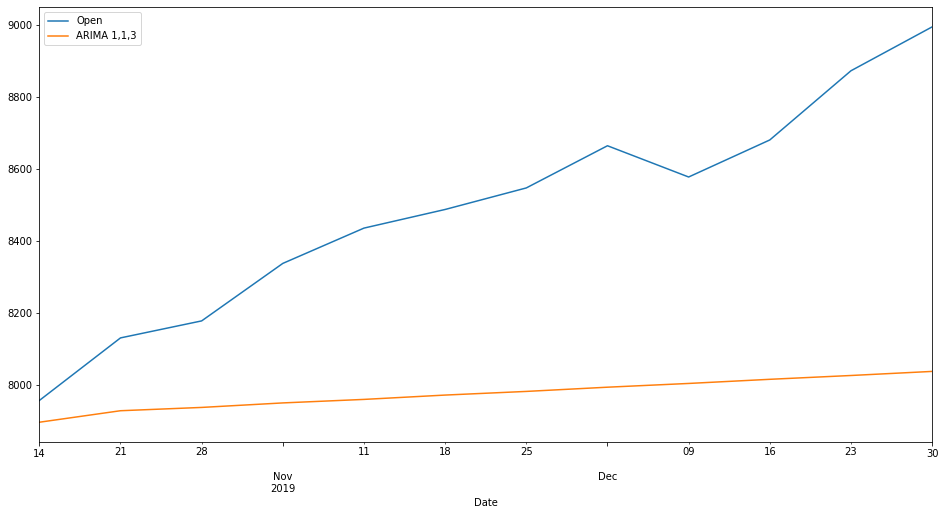

In [16]:
test['Open'].plot(figsize = (16, 8), legend = True)
predictions.plot(legend = True)

### Evaluating the Predictions

In [17]:
print('RMSE = %s' % np.sqrt(mean_squared_error(test['Open'], predictions)))

RMSE = 570.7524855020775


In [18]:
print('Test Set Mean = %s' % test['Open'].mean())

Test Set Mean = 8489.32724202474


In [19]:
print('Predictions Mean = %s' % predictions.mean())

Predictions Mean = 7976.557569821096


### Forecasting into the Future

In [20]:
fcast_model = ARIMA(dataset['Open'], order = (1, 1, 3))
fcast_result = fcast_model.fit()
fcast = fcast_result.predict(start = len(dataset),
                             end = len(dataset) + 12, typ = 'levels').rename('ARIMA 1, 1, 3 Forcast') # We will only forecast for 12 weeks
fcast

2020-01-06    8996.495335
2020-01-13    9007.155965
2020-01-20    9012.326447
2020-01-27    9031.538052
2020-02-03    9038.951147
2020-02-10    9056.278324
2020-02-17    9065.274871
2020-02-24    9081.271500
2020-03-02    9091.386082
2020-03-09    9106.443246
2020-03-16    9117.347245
2020-03-23    9131.741076
2020-03-30    9143.202462
Freq: W-MON, Name: ARIMA 1, 1, 3 Forcast, dtype: float64

### Plotting the forecast onto main dataset

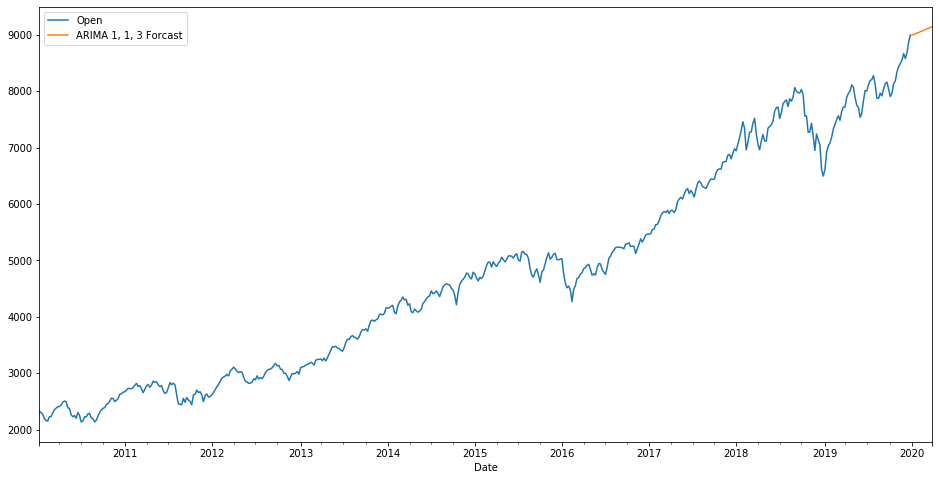

In [21]:
dataset['Open'].plot(figsize = (16, 8), legend = True)
fcast.plot(legend = True)